In [1]:
!pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import os
import re

/tmp/ipykernel_357538/561376880.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def parse_usages(usage_string):
    usages = []
    usage_string = usage_string.replace("),C",")\tC")
    usage_string = usage_string.split("\t")
    usages_pattern = r"[A-Za-z]PU: \([^)]*\)"
    cpu_usage_pattern = r"maxrss: (\d+MiB)"
    gpu_usage_pattern = r"U: (\d+MiB)"
    mapper = {
        0: "before (MiB)",
        1: "after (MiB)"
    }
    for i, moments in enumerate(usage_string):
            matches = re.findall(usages_pattern, moments)
            for match in matches:
                match = match.replace(",","")
                cpu = re.findall(cpu_usage_pattern, match)
                gpu = re.findall(gpu_usage_pattern, match)
                if match[:3] == "CPU":
                    usages.append({f"{match[:3]}-{mapper[i]}":int(cpu[0].replace("MiB",""))})
                elif match[:3] == "GPU":
                    usages.append({f"{match[:3]}-{mapper[i]}":int(gpu[0].replace("MiB",""))})                    
    return usages
            
        

In [3]:
def parse_file(file):
    lazy_load = True if "--lazy-load" in file else False
    vllm_tensorized = True if "--plaid-mode"in file else False
    df = pd.read_csv(file)
    rows = []
    for i in range(len(df)):
        row = df.iloc[i]
        load_format = row.name[0]
        model = row.name[1]
        duration = row[-2]
        cache = row[-1]
        to_concat = row.name[2:]
        mem_before_after = ",".join(to_concat)
        vals = {}
        vals.update({"load_format":load_format})
        vals.update({"model":model})
        for dic in parse_usages(mem_before_after):
            vals.update(dic)
        vals.update({"duration(s)":duration})
        vals.update({"cache_hit":cache})
        vals.update({"lazy_load":lazy_load})
        vals.update({"vllm_tensorized":vllm_tensorized})
        cpu_diff = vals["CPU-after (MiB)"] - vals["CPU-before (MiB)"]
        gpu_diff = vals["GPU-after (MiB)"] - vals["GPU-before (MiB)"]
        vals.update({"CPU-diff-MiB": cpu_diff})
        vals.update({"GPU-diff-MiB": gpu_diff})
        rows.append(vals)
    return pd.DataFrame(rows)


In [4]:
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)

In [5]:
base_file = "new_tensorizer"

In [6]:
def get_data_count(benchmark_file):
    return int(benchmark_file.split("_")[2])

In [7]:
def get_highest_data_count(benchmark_files):
    counts = list(map(get_data_count, benchmark_files))
    return max(counts)

In [8]:
files = [file for file in os.listdir(base_file) if file.isnumeric()]
print(files)
dfs = []
for file in files:
    file = f"{base_file}/{file}"
    load_type = os.listdir(file)[0]
    for i, model in enumerate(os.listdir(f"{file}/{load_type}")):
        model_ref_1 = os.listdir(f"{file}/{load_type}")[i]
        model_ref_2 = os.listdir(f"{file}/{load_type}/{model_ref_1}")[0]
        localities = os.listdir(f"{file}/{load_type}/{model_ref_1}/{model_ref_2}")
        for locality in localities:
            subpath = f"{file}/{load_type}/{model_ref_1}/{model_ref_2}/{locality}"
            benchmark_files = os.listdir(subpath)
            benchmark_files = [file for file in benchmark_files if not file.startswith(".")]
            highest_digit = get_highest_data_count(benchmark_files)
            benchmark = f"results_checkpoint_{highest_digit}_vals.csv"
            print(f"Reading {subpath}/{benchmark}")
            created_df = parse_file(f"{subpath}/{benchmark}")
            created_df['local_or_not_local'] = locality
            dfs.append(created_df)
df = pd.concat(dfs)

['1711595700', '1711473670', '1711473529', '1711638207', '1711479047', '1711637892', '1711508525', '1711473613', '1711595404', '1711508700', '1711473705', '1711635966', '1711479024', '1711638252', '1711508764', '1711636070', '1711636001', '1711508834', '1711635971', '1711478924', '1711635986', '1711595648', '1711595630', '1711637830', '1711595446', '1711635990', '1711595779', '1711638327', '1711638222']
Reading new_tensorizer/1711595700/safetensors2/mistralai/Mistral-7B-v0.1/non-local/results_checkpoint_250_vals.csv
Reading new_tensorizer/1711595700/safetensors2/mistralai/Mistral-7B-v0.1/local/results_checkpoint_250_vals.csv
Reading new_tensorizer/1711595700/safetensors2/meta-llama/Llama-2-13b-hf/non-local/results_checkpoint_250_vals.csv
Reading new_tensorizer/1711595700/safetensors2/meta-llama/Llama-2-13b-hf/local/results_checkpoint_250_vals.csv
Reading new_tensorizer/1711473670/tensorizer3/EleutherAI/pythia-1.4b/local/results_checkpoint_310_vals.csv
Reading new_tensorizer/1711473529/

In [9]:
set(dfs[-1]['model'])

{'EleutherAI/pythia-1.4b'}

In [10]:
df['model'] = [x.split("/")[1] for x in df['model']]

In [11]:
df = df.drop_duplicates()

In [12]:
set(df[df['load_format'] == 'npcache'].model)

set()

In [13]:
gbs = {
    "pythia-1.4b": 2.86,
    "Mistral-7B-v0.1": 13.4966,
    "Llama-2-13b-hf": 26
}

In [14]:
44792/8.117432

5518.001259511629

In [15]:
set(df[df['model'] == 'pythia-1.4b']['load_format'])

{'safetensors', 'tensorizer'}

In [16]:
df['GB/s'] = df['GPU-diff-MiB']/df['duration(s)']

In [17]:
df['GB/s'] = df['GB/s'] / 1000

In [29]:
tensorizer_mask = (df['load_format'] == 'tensorizer') & (df['local_or_not_local'] == 'non-local')
safetensors_mask = (df['load_format'] == 'safetensors') & (df['local_or_not_local'] == 'local')

In [30]:
df1 = df[tensorizer_mask]
df2 = df[safetensors_mask]
df = pd.concat([df1, df2])

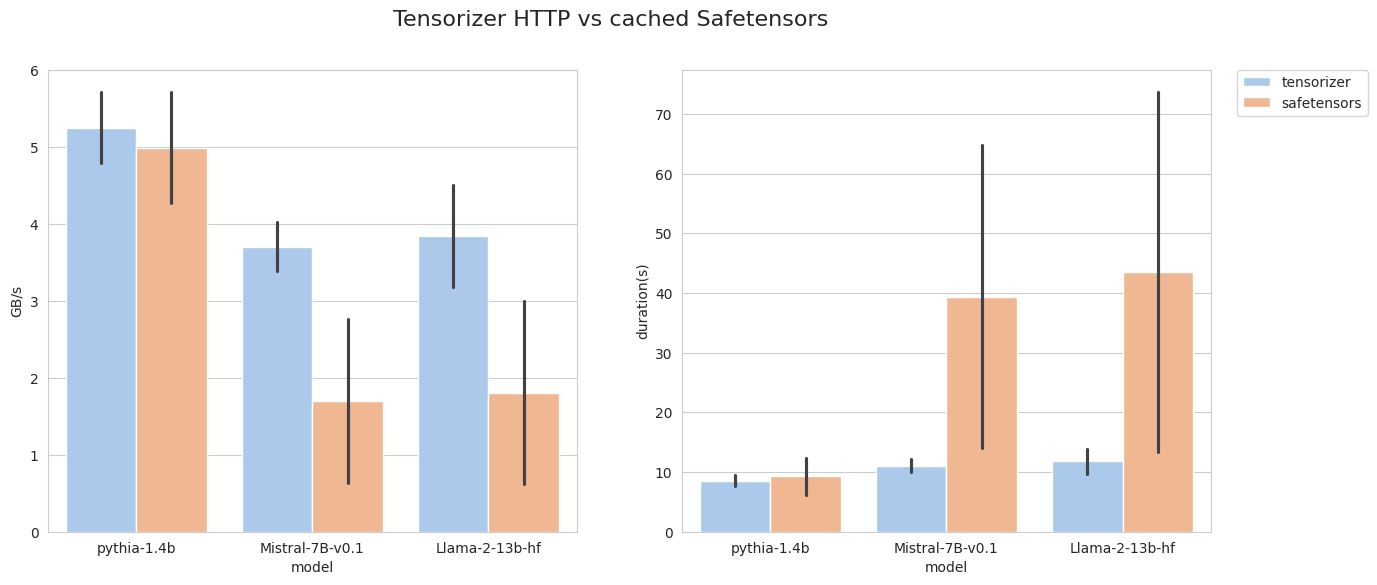

In [40]:
import matplotlib.pyplot as plt

# Create a new figure
fig = plt.figure(figsize=(15, 6))

# Add a title for the whole figure
fig.suptitle('Tensorizer HTTP vs cached Safetensors', fontsize=16)

# Create the first subplot for GB/s
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 cols, subplot 1
sns.barplot(x='model', y='GB/s', hue='load_format', data=df, ci='sd', palette='pastel', ax=ax1)
ax1.get_legend().remove()  # Remove the legend from the first plot

# Create the second subplot for duration(s)
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 cols, subplot 2
sns.barplot(x='model', y='duration(s)', hue='load_format', data=df, ci='sd', palette='pastel', ax=ax2)

# Move the legend outside of the plot
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Save the figure
plt.savefig("Benchmark.jpg", bbox_inches='tight')

In [11]:
set(df['model'])

{'meta-llama/Llama-2-13b-hf'}

In [19]:
grouped.mean()['local']

group
EleutherAI/pythia-1.4btensorizer--                       8.994465
EleutherAI/pythia-1.4btensorizer--lazy_load              9.278009
EleutherAI/pythia-1.4btensorizer-plaid_mode-             8.781135
EleutherAI/pythia-1.4btensorizer-plaid_mode-lazy_load    9.126989
Name: duration(s), dtype: float64